# Deterministic Interpolation using Inverse Distance Weighted

*Spatial interpolation is the process of estimating unknown values across space by making use of the values that we do know and using the assumptions that we can make based on Tobler's First Law of Geography. It may also sometimes be referred to as spatial predicition. Inverse Distance Weighted (IDW) interpolation is a deterministic interpolation method (meaning that the outputs for a given set of inputs will always be the same) that makes use of a fundamental mathematical concept in GIScience known as the Weighted Linear Combination (WLC).*

Last updated: Nov 30, 2023

In [1]:
# Imports
import os

os.environ["USE_PYGEOS"] = "0"

import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from shapely import Point

# Implementing IDW from Scratch

With an understanding of how IDW works mathematically, we can now implement it in Python. We do this by manually constructing a grid (fishnet) where we will be able to take some known values for some given locations in the grid to predict the rest of the unknown values.

Here is the problem at hand:

Given the known values: 90 at (1, 4), 85 at (16, 5), 80 at (14, 10), 87 at (5, 20), 92 at (21, 16), use IDW to predict the unknown values in a grid of size 25 x 25, where the bottom left coordinates are (0, 0) and the top right coordinates are (24, 24).

A brief overview of the grid's coordinates is featured below.

|<span style="font-weight:normal">(24,0)</span>|<span style="font-weight:normal">(24,1)</span>|<span style="font-weight:normal">...</span>|<span style="font-weight:normal">(24,24)</span>|
|:------:|:------:|:---:|:-------:|
|   ...  |   ...  | ... |   ...   |
|  (0,1) |  (1,1) | ... |  (24,1) |
|  (0,0) |  (1,0) | ... |  (24,0) |

### Creating Known Points

To start, let's create Point objects representing the values that we know. We will store our variable of interest as the Z coordinate in the point (both because this is a valid approach and to simplify the process of accessing the values).

In [2]:
# Our Known Points
known_point_1 = Point(1, 4, 90)
known_point_2 = Point(16, 5, 85)
known_point_3 = Point(14, 10, 80)
known_point_4 = Point(5, 20, 87)
known_point_5 = Point(21, 16, 92)

# A List of the Points
known_point_list = [known_point_1, known_point_2, known_point_3, known_point_4, known_point_5]

# A List of Tuples Containing X/Y Coordinates for each Known Point
known_point_tuples_list = [(pt.x, pt.y) for pt in known_point_list]

### Making Predictions

With the known points created, we can now use them in conjunction with the mathematical formulas for IDW to start making some predictions.

In [3]:
# Set Alpha Value for IDW
alpha = 2

# Create List for Storing Output
output = []

In [4]:
# Nested For Loop to Iterate through all X/Y coordinates in the grid
for y in range(0, 25):
    for x in range(0, 25):
        # If the X/Y coordinate is a Known Value, We don't need to make a Prediction
        if (x, y) in known_point_tuples_list:
            pass
        
        # Otherwise, Make a Prediction
        else:
            # Set Starting Values for IDW Formula
            total_numerator = 0
            total_denominator = 0
            
            # Create Point Object for Current Point
            p = Point(x, y)
            
            # Iteratively Compare to each Known Point
            for kp in known_point_list:
                # Calculate Inverse Distance from Point to Known Point
                inv_dist = (1 / kp.distance(p))**alpha
                
                # Calculate Inverse Distance * the Known Point's Variable of Interest
                numerator_value = inv_dist * kp.z
                
                # Add Numerator for this Known Point to Total Numerator
                total_numerator += numerator_value
                
                # Add Inverse Distance for this Known Point to Total Denominator
                total_denominator += inv_dist
                
            # After all Known Points Iterated through, Calculate Predicition
            prediction = round((total_numerator / total_denominator), 2)
            
            # Append Tuple of (X, Y, Prediction) to Output List
            output.append((x, y, prediction))
            
# For the Known Values, Add them to Output List
for p in known_point_list:
    output.append((p.x, p.y, p.z))

In [5]:
# Display the Output List
print(output)

[(0, 0, 89.2), (1, 0, 89.17), (2, 0, 89.05), (3, 0, 88.83), (4, 0, 88.49), (5, 0, 88.06), (6, 0, 87.58), (7, 0, 87.07), (8, 0, 86.59), (9, 0, 86.15), (10, 0, 85.79), (11, 0, 85.5), (12, 0, 85.29), (13, 0, 85.16), (14, 0, 85.07), (15, 0, 85.04), (16, 0, 85.02), (17, 0, 85.03), (18, 0, 85.06), (19, 0, 85.11), (20, 0, 85.17), (21, 0, 85.26), (22, 0, 85.35), (23, 0, 85.46), (24, 0, 85.57), (0, 1, 89.47), (1, 1, 89.47), (2, 1, 89.36), (3, 1, 89.12), (4, 1, 88.74), (5, 1, 88.24), (6, 1, 87.68), (7, 1, 87.09), (8, 1, 86.53), (9, 1, 86.04), (10, 1, 85.64), (11, 1, 85.34), (12, 1, 85.13), (13, 1, 85.01), (14, 1, 84.95), (15, 1, 84.93), (16, 1, 84.94), (17, 1, 84.95), (18, 1, 84.98), (19, 1, 85.03), (20, 1, 85.11), (21, 1, 85.2), (22, 1, 85.31), (23, 1, 85.43), (24, 1, 85.56), (0, 2, 89.7), (1, 2, 89.73), (2, 2, 89.64), (3, 2, 89.38), (4, 2, 88.96), (5, 2, 88.39), (6, 2, 87.74), (7, 2, 87.07), (8, 2, 86.44), (9, 2, 85.89), (10, 2, 85.46), (11, 2, 85.15), (12, 2, 84.96), (13, 2, 84.87), (14, 2, 8

### Visualizing the Predictions

With predictions made, we can now visualize what they look like across space. To do this, we can convert the points to a GeoDataFrame and visualize them as points, or slightly change the settings of our point visualization to make it look similar to a raster.

In [6]:
# Convert Output to DataFrame
df = pd.DataFrame(output, columns = ["X", "Y", "VAL"])

df.head()

,X,Y,VAL
0,0.0,0.0,89.20
1,1.0,0.0,89.17
2,2.0,0.0,89.05
3,3.0,0.0,88.83
4,4.0,0.0,88.49


In [7]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.X, df.Y))

gdf.head()

,X,Y,VAL,geometry
0,0.0,0.0,89.20,POINT (0.00000 0.00000)
1,1.0,0.0,89.17,POINT (1.00000 0.00000)
2,2.0,0.0,89.05,POINT (2.00000 0.00000)
3,3.0,0.0,88.83,POINT (3.00000 0.00000)
4,4.0,0.0,88.49,POINT (4.00000 0.00000)


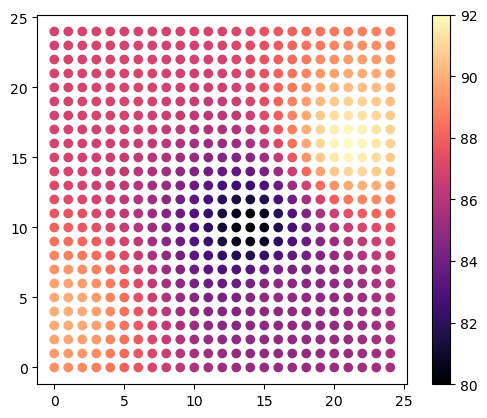

In [8]:
# Making a Basic Plot
gdf.plot(column = "VAL", legend = True, cmap = "magma");

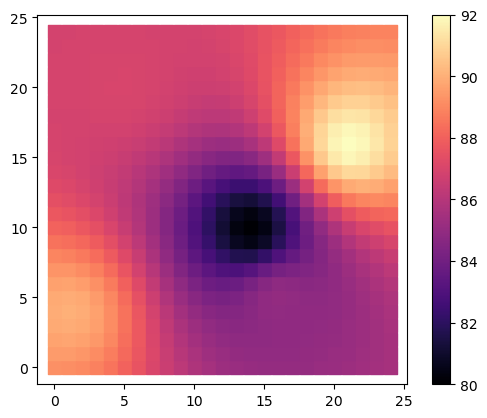

In [9]:
#  Making a Plot of Points to look like a Raster
gdf.plot(column = "VAL", legend = True, cmap = "magma", marker = "s", markersize = 90);

### Converting Predicted Points to a 2D Array (Raster)

In addition to viewing the predictions as points (which are kind of like the centroids of raster cells), we can also convert the points to a two-dimensional array (a single-band raster). To do this, we need to use NumPy to sort and transform the data from a one-dimensional list into a two-dimensional array that is read from top-left to bottom-right.

In [10]:
# Sort Output by Y, X
sorted_output = sorted(output, key=lambda element: (element[1], element[0]))

In [11]:
# Remove Coordinates - No Spatial Reference in this Example
sorted_values = [element[2] for element in sorted_output]

In [12]:
# Transform into 2D NumPy Array of size 25 x 25
array = np.reshape(np.array(sorted_values), (25, 25))

In [13]:
# Reorder Array to Correct Orientation (Starting at top-left)
flipped_array = np.flip(array, 0)

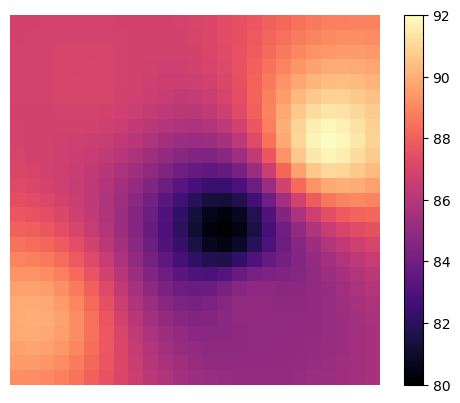

In [14]:
# Making a Basic Plot of the Array
plt.imshow(flipped_array, cmap = "magma")
plt.colorbar()
plt.axis("off")
plt.show()